In [7]:
#首先先导入需要常用到的数据包，一般放在最前面。
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文
plt.rcParams['axes.unicode_minus']=False #显示正负号
%config InlineBackend.figure_format='svg' #增加清晰度
plt.style.use('ggplot')#设定绘图风格

-- 导入数据并命名，方便调取

In [77]:
area=pd.read_csv(r".\data20200206\state-areas.csv") 

In [78]:
abb=pd.read_csv(r".\data20200206\state-abbrevs.csv")

In [79]:
pop=pd.read_csv(r".\data20200206\state-population.csv")

##  将人口数据和各州简称数据进行合并

In [80]:
area.head(2) #面积表

,state,area (sq. mi)
0,Alabama,52423
1,Alaska,656425


In [81]:
abb.head(2) # 简称表

,state,abbreviation
0,Alabama,AL
1,Alaska,AK


In [82]:
pop.head(2) #人口表

,state/region,ages,year,population
0,AL,under18,2012,1117489.0
1,AL,total,2012,4817528.0


In [29]:
#题目要求是合并人口 和简称数据，调用abb表和 pop表即可，
abb_pop=pd.merge(abb,pop,left_on='abbreviation',right_on='state/region',how='outer') #列索引不同用merge用法

- how选择outer防止数据不完整，提取出所有数据的并集

In [30]:
abb_pop.head(5)

,state,abbreviation,state/region,ages,year,population
0,Alabama,AL,AL,under18,2012,1117489.0
1,Alabama,AL,AL,total,2012,4817528.0
2,Alabama,AL,AL,under18,2010,1130966.0
3,Alabama,AL,AL,total,2010,4785570.0
4,Alabama,AL,AL,under18,2011,1125763.0


## 将合并数据中重复的abbreviation列删除

In [31]:
#从前五行看，因为合并的缘故该数据表有重复的两列，需要删掉多余的一列
abb_pop.drop(labels="abbreviation",axis=1,inplace=True)  #drop() labels=列名，axis=1就是代表和运算方向一致 是水平方向/横向

In [32]:
# 重新看数据表就发现多余的列已经被删除。
abb_pop.head()

,state,state/region,ages,year,population
0,Alabama,AL,under18,2012,1117489.0
1,Alabama,AL,total,2012,4817528.0
2,Alabama,AL,under18,2010,1130966.0
3,Alabama,AL,total,2010,4785570.0
4,Alabama,AL,under18,2011,1125763.0


## 查看缺失数据的列

In [12]:
#查看缺失有两种方法，一种是info查询，一种是isnull/notnull
abb_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544 entries, 0 to 2543
Data columns (total 5 columns):
state           2448 non-null object
state/region    2544 non-null object
ages            2544 non-null object
year            2544 non-null int64
population      2524 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 119.2+ KB


- 可以看出 state列和 population列是有缺失值的和总数2544对不上

In [33]:
abb_pop.isnull().any(axis=0)#另外一种方法 notnull().all(axis=0)

state            True
state/region    False
ages            False
year            False
population       True
dtype: bool

-- 这里的axis=0，意思是如果要对表abb_pop进行缺失值查询，一定是从state第一行查到最后一行，这样的运算方向是纵向，故而axis=0

## 哪些state/region使得state的值为NaN，进行去重操作

In [83]:
#首先寻找空值的行，得到布尔值
abb_pop["state"].isnull()#取Series

0       False
1       False
2       False
3       False
4       False
        ...  
2539    False
2540    False
2541    False
2542    False
2543    False
Name: state, Length: 2544, dtype: bool

In [38]:
nan=abb_pop.loc[abb_pop["state"].isnull()]#布尔值 带入索引方式loc
nan

,state,state/region,ages,year,population
2448,NaN,PR,under18,1990,NaN
2449,NaN,PR,total,1990,NaN
2450,NaN,PR,total,1991,NaN
2451,NaN,PR,under18,1991,NaN
2452,NaN,PR,total,1993,NaN
...,...,...,...,...,...
2539,NaN,USA,total,2010,309326295.0
2540,NaN,USA,under18,2011,73902222.0
2541,NaN,USA,total,2011,311582564.0
2542,NaN,USA,under18,2012,73708179.0


In [20]:
#取出简称,去重 就是去除重复 要用unique
abb2["state/region"].unique()

array(['PR', 'USA'], dtype=object)

-- 结果我们发现，只有简称为PR和USA的state全称项为空值

## 为state项为NaN的补上正确的值，从而去除掉state这一列所有的NaN

In [25]:
abb_pop

,state,state/region,ages,year,population
0,Alabama,AL,under18,2012,1117489.0
1,Alabama,AL,total,2012,4817528.0
2,Alabama,AL,under18,2010,1130966.0
3,Alabama,AL,total,2010,4785570.0
4,Alabama,AL,under18,2011,1125763.0
...,...,...,...,...,...
2539,NaN,USA,total,2010,309326295.0
2540,NaN,USA,under18,2011,73902222.0
2541,NaN,USA,total,2011,311582564.0
2542,NaN,USA,under18,2012,73708179.0


In [20]:
#因为为空的有两项，所以不能用直接填充fillna，而是拆分
abb_pop['state/region']=="PR"

0       False
1       False
2       False
3       False
4       False
        ...  
2539    False
2540    False
2541    False
2542    False
2543    False
Name: state/region, Length: 2544, dtype: bool

In [40]:
#取出简称为PR的项
abb_pop.loc[abb_pop['state/region']=="PR"]

,state,state/region,ages,year,population
2448,NaN,PR,under18,1990,NaN
2449,NaN,PR,total,1990,NaN
2450,NaN,PR,total,1991,NaN
2451,NaN,PR,under18,1991,NaN
2452,NaN,PR,total,1993,NaN
2453,NaN,PR,under18,1993,NaN
2454,NaN,PR,under18,1992,NaN
2455,NaN,PR,total,1992,NaN
2456,NaN,PR,under18,1994,NaN
2457,NaN,PR,total,1994,NaN


In [42]:
# abb_pop.loc[abb_pop['state/region']=="PR"].fillna(value='PUERTO RICO')
#如果直接用fillna 因为不能定位，所以population列所有的空值也被填充

-- 如果直接fillna,不能定位，所以这里需要用到***索引定位赋值***的方法

In [43]:
#取出简称为PR列的行索引
index1=abb_pop.loc[abb_pop['state/region']=="PR"].index#(取出符合条件的行索引)
index1

Int64Index([2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458,
            2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469,
            2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480,
            2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491,
            2492, 2493, 2494, 2495],
           dtype='int64')

In [45]:
#需要批量定位赋值，既为行索引为index1且列索引为state的所有值赋值为puerto rico
abb_pop.loc[index1,'state']='PUERTO RICO'#用loc行列索引定位赋值，index1中的state列进行矩阵赋值，用普通索引

In [37]:
abb_pop.loc[abb_pop['state/region']=="PR"].head(5) #验证一下

,state,state/region,ages,year,population
2448,PUERTO RICO,PR,under18,1990,NaN
2449,PUERTO RICO,PR,total,1990,NaN
2450,PUERTO RICO,PR,total,1991,NaN
2451,PUERTO RICO,PR,under18,1991,NaN
2452,PUERTO RICO,PR,total,1993,NaN


In [46]:
## 同理再给美国赋值一下 
abb_pop['state']=="USA"  
abb_pop.loc[abb_pop['state/region']=="USA"]
index2=abb_pop.loc[abb_pop['state/region']=="USA"].index
abb_pop.loc[index2,'state']='United Statement Of America'

In [47]:
abb_pop

,state,state/region,ages,year,population
0,Alabama,AL,under18,2012,1117489.0
1,Alabama,AL,total,2012,4817528.0
2,Alabama,AL,under18,2010,1130966.0
3,Alabama,AL,total,2010,4785570.0
4,Alabama,AL,under18,2011,1125763.0
...,...,...,...,...,...
2539,United Statement Of America,USA,total,2010,309326295.0
2540,United Statement Of America,USA,under18,2011,73902222.0
2541,United Statement Of America,USA,total,2011,311582564.0
2542,United Statement Of America,USA,under18,2012,73708179.0


In [48]:
abb_pop.info() #查看info说明state列下面已经没有空值都已经赋值了

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544 entries, 0 to 2543
Data columns (total 5 columns):
state           2544 non-null object
state/region    2544 non-null object
ages            2544 non-null object
year            2544 non-null int64
population      2524 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 199.2+ KB


## 合并各州面积数据area
    

In [57]:
#合并各州面积数据area pop 和area融合找共同项 因为简称的关系，所以要合并三个表
abb_pop_area=pd.merge(abb_pop,area,on="state",how="outer")
abb_pop_area.tail()

,state,state/region,ages,year,population,area (sq. mi)
2540,United Statement Of America,USA,under18,2011.0,73902222.0,NaN
2541,United Statement Of America,USA,total,2011.0,311582564.0,NaN
2542,United Statement Of America,USA,under18,2012.0,73708179.0,NaN
2543,United Statement Of America,USA,total,2012.0,313873685.0,NaN
2544,Puerto Rico,NaN,NaN,NaN,NaN,3515.0


## area列有缺失值，请找出并去除含有缺失值的行

In [58]:
 #找出哪些是缺失行
abb_pop_area['area (sq. mi)'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
2540     True
2541     True
2542     True
2543     True
2544    False
Name: area (sq. mi), Length: 2545, dtype: bool

In [59]:
#找出缺失行的行索引
drop_index=abb_pop_area.loc[abb_pop_area['area (sq. mi)'].isnull()].index 

In [60]:
#精确删除，指定的索引行
abb_pop_area.drop(labels=drop_index,axis=0,inplace=True) #将面积序列的空值行索引带入drop里面直接去掉，drop可以去除列，也可以带入行

In [55]:
abb_pop_area.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2449 entries, 0 to 2544
Data columns (total 6 columns):
state            2449 non-null object
state/region     2448 non-null object
ages             2448 non-null object
year             2448 non-null float64
population       2448 non-null float64
area (sq. mi)    2449 non-null float64
dtypes: float64(3), object(3)
memory usage: 133.9+ KB


## 找出2010年全民人口数据 

In [61]:
#查找范围，要求是全民total和2010 用query取范围
abb_pop_area.query('ages=="total" & year == 2010').head()

,state,state/region,ages,year,population,area (sq. mi)
3,Alabama,AL,total,2010.0,4785570.0,52423.0
91,Alaska,AK,total,2010.0,713868.0,656425.0
101,Arizona,AZ,total,2010.0,6408790.0,114006.0
189,Arkansas,AR,total,2010.0,2922280.0,53182.0
197,California,CA,total,2010.0,37333601.0,163707.0


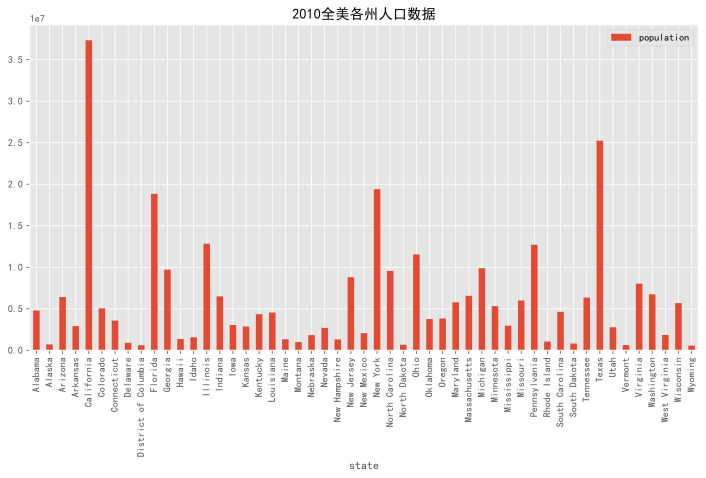

In [63]:
 #描述全美的2010人口分布图，将问题可视化出来
abb_pop_area.query('ages=="total" & year == 2010').set_index(['state'])['population'].plot(kind='bar',figsize=(12,6),title='2010全美各州人口数据')
plt.legend()

## 计算各州的人口密度 （人数/面积）

In [64]:
#增加一个密度列
abb_pop_area["density"]=abb_pop_area["population"]/abb_pop_area["area (sq. mi)"]
abb_pop_area.head()

,state,state/region,ages,year,population,area (sq. mi),density
0,Alabama,AL,under18,2012.0,1117489.0,52423.0,21.316769
1,Alabama,AL,total,2012.0,4817528.0,52423.0,91.897221
2,Alabama,AL,under18,2010.0,1130966.0,52423.0,21.573851
3,Alabama,AL,total,2010.0,4785570.0,52423.0,91.287603
4,Alabama,AL,under18,2011.0,1125763.0,52423.0,21.474601


### 找出2012年 人口密度最大的五个州，并画图

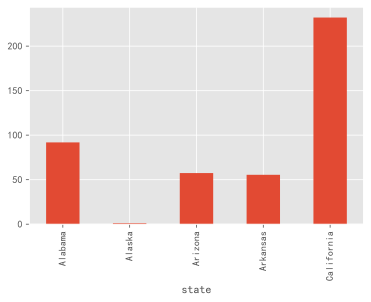

In [65]:
abb_pop_area.query('ages=="total" & year==2012').set_index(['state'])['density'].head(5).plot(kind='bar')

## 排序并找出人口密度最高的五个州 

In [73]:
df1=abb_pop_area.sort_values(by="density",ascending=False)
abb_pop_area.sort_values(by="density",ascending=False)['state'].unique()[0:5].tolist() #行索引可以直接取【0-5】也就是1,5行

['District of Columbia',
 'New Jersey',
 'Rhode Island',
 'Connecticut',
 'Massachusetts']

In [74]:
#改成2010年的人口密度排序,因为题目的不同年份数值对比其实并不准确，应该是同样年下的处理
df1['year']==2010
df2=df1.loc[df1['year']==2010]
df2.groupby('state').max().sort_values(by="density",ascending=False).head(5)

,state/region,ages,year,population,area (sq. mi),density
state,,,,,,
District of Columbia,DC,under18,2010.0,605125.0,68.0,8898.897059
New Jersey,NJ,under18,2010.0,8802707.0,8722.0,1009.253268
Rhode Island,RI,under18,2010.0,1052669.0,1545.0,681.339159
Connecticut,CT,under18,2010.0,3579210.0,5544.0,645.600649
Massachusetts,MA,under18,2010.0,6563263.0,10555.0,621.815538


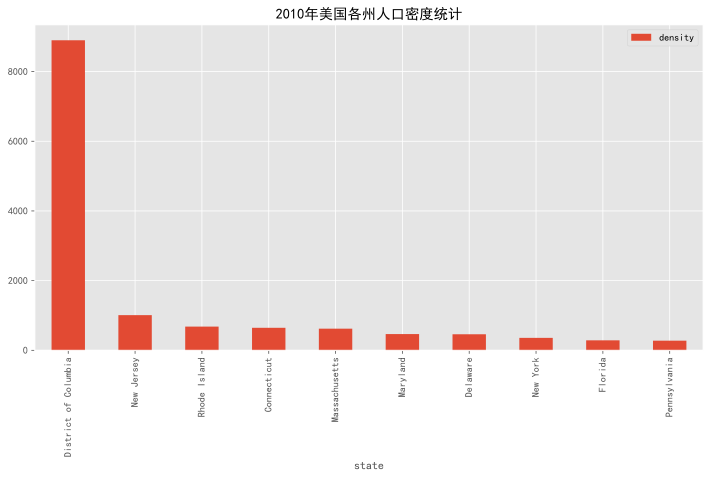

In [75]:
df2.drop_duplicates('state').set_index(['state'])['density'].head(10).plot(kind='bar',figsize=(12,6),title='2010年美国各州人口密度统计')
plt.legend()